# Inpainting su CIFAR-10

L'obiettivo di questo progetto è quello di costruire ed allenare una ree per inpainting su immagini del dataset CIFAR-10. 

l'inpainting è una tecnica di restauro per cui porzioni danneggiate, deteriorate o mancanti di una immagine sono rimepite cercando di ottenere una
ricostruzione completa.

Nel nostro caso, creiamo la porzione di immagine che deve essere riempita effettuando un crop su immagini di CIFAR-10 di un'area rettangolare di dimensione fissata.

la rete deve essere allenata sul training set, e testata sul test set.
Potete ricavare un validation set aggiuntivo a partire dal test set, se lo ritenete opportuno.

la metrica ina base alla quale dovrete valutare la qualità della vostra ricostruzione è la distanza quadratica media (MSE).

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.datasets import cifar10

Carichiamo il dataset e normalizziamolo.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 4s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


Visualizziamo qualche esempio

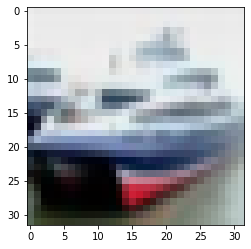

In [ ]:
plt.imshow(x_test[1])
plt.show()

Adeso mascheriamo una parte dell'input. L'obiettivo del modello reta sarà la ricostruzione di questa parte mancante.

In [ ]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

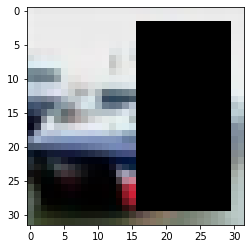

In [ ]:
plt.imshow(masked_x_test[1])
plt.show()

# Approcci e valutazione

La rete deve prendere in input l'immagine mascherata e riempire la parte mancante.

Per l'output, potete seguire essenizialmente due approcci:
*   restituire l'intera immagine
*   restituire solo il crop mancante

Nel primo caso, il mean square error deve essere valutato sul tutta l'immagine.
Mel secondo caso potete limitarvi al calcolo sul crop, dato che per la parte restante l'errore sarà nullo.

Se intendete seguire un approccio diverso, potete chiedere conferma della sua legittimità per email o tramite teams.




# Cosa consegnare

Dovete consegnare un singolo notebook che comprenda il codice, la storia del training, e la misurazione dell'errore (MSE) sul test set.

Buon Lavoro!

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, metrics
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import mean_squared_error


def mask(X, coords):
  x0, y0, x1, y1 = coords
  X[:, x0:x1, y0:y1] = 0
  return X

# Carica il dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

masked_x_test = mask(np.copy(x_test),(2,16,30,30))
masked_x_train = mask(np.copy(x_train), (2, 16, 30, 30))

inputs = layers.Input(shape=(32, 32, 3))

# Encoder
encode = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(inputs)
encode = layers.Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(encode)
encode = layers.MaxPooling2D((2, 2))(encode)
encode = layers.Conv2D(128, (3, 3),activation='LeakyReLU', padding='same')(encode)
encode = layers.Conv2D(256, (3, 3), activation='LeakyReLU', padding='same')(encode)
encode = layers.Dense(128, activation='LeakyReLU')(encode)
encode = layers.Conv2D(64, (3, 3),activation='LeakyReLU', padding='same')(encode)
encoded = layers.MaxPooling2D((2, 2))(encode)

# Decoder
decode = layers.Conv2D(128, (3, 3), activation='swish', padding='same')(encoded)
decode = layers.UpSampling2D((4, 4))(decode)
decode = layers.Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(decode)
decode = layers.Conv2D(64, (3, 3), activation='LeakyReLU', padding='same')(decode)
decode = layers.Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(decode)
#decode = layers.UpSampling2D((2, 2))(decode)
decode = layers.Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(decode)
encode = layers.Conv2D(64, (3, 3),activation='LeakyReLU', padding='same')(encode)
decode = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decode)

autoencoder = keras.Model(inputs, decode)
autoencoder.compile(optimizer=  'adam', loss='mean_squared_error', metrics='accuracy')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0000001)

autoencoder.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

autoencoder.fit(masked_x_train, x_train, epochs=30, batch_size=64, validation_data=(masked_x_test, x_test), shuffle=True, callbacks=[early_stopping, reduce_lr])


image range is 0, 255
new image range is 0.0, 1.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       295168    
           

In [ ]:
predictions = autoencoder.predict(masked_x_test)
#Reshape dati su due dimensioni per usarli nell'MSE
x_test_flat = x_test.reshape(-1)
predictions_flat = predictions.reshape(-1)
mse = mean_squared_error(x_test_flat, predictions_flat)
print("Mean Squared Error:", mse)

313/313 [==============================] - 4s 13ms/step
Mean Squared Error: 0.008345876


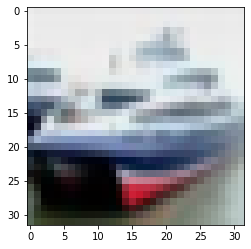

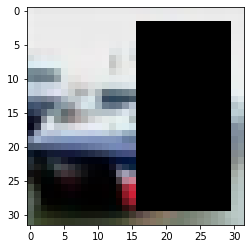

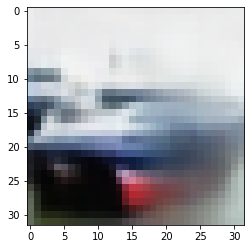

In [ ]:
plt.imshow(x_test[1])
plt.show()
plt.imshow(masked_x_test[1])
plt.show()
plt.imshow(predictions[1])
plt.show()